In [1]:
import os
import sys

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import custom_loss_functions
import utils
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from numpy import expand_dims

import requests
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import datetime
import csv
import pandas as pd
import json

import argparse

Using TensorFlow backend.


In [2]:
tf.__version__

'2.1.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [4]:
if tf.config.list_physical_devices('GPU'):
    print("GPU was detected.")

GPU was detected.


# Load trained model

In [5]:
# model_path = "saved_models/MSE/04-02-2020_09:59:44/CAE_e100_b8_0"
# model_path = "saved_models/SSIM/05-02-2020_14:41:02/CAE_e150_b12_0.h5"
# model_path = "saved_models/L2/05-02-2020_20:36:45/CAE_e150_b12_0.h5"
# model_path = "saved_models/MSE/06-02-2020_14:55:39/CAE_e150_b12_0.h5"
model_path = "saved_models/MSE/06-02-2020_16:15:33/CAE_e200_b12_0.h5"

In [6]:
# import importlib
# importlib.reload(utils)

In [7]:
model, train_setup, history = utils.load_model_HDF5(model_path)

directory = train_setup["directory"]
val_data_dir = os.path.join(directory, "train")
color_mode = train_setup["color_mode"]
validation_split = train_setup["validation_split"]
channels = train_setup["channels"]
loss = train_setup["loss"]
batch_size = train_setup["batch_size"]
learning_rate = train_setup["learning_rate"]

In [8]:
import pandas as pd

In [9]:
history[['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']].head(10)

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,0.593805,0.593805,0.415842,0.415842
1,0.420139,0.420139,0.335574,0.335574
2,0.328653,0.328653,0.233594,0.233594
3,0.199700,0.199700,0.099009,0.099009
4,0.086010,0.086010,0.050277,0.050277
5,0.044107,0.044107,0.021024,0.021024
6,0.032731,0.032731,0.015094,0.015094
7,0.030123,0.030123,0.014353,0.014353
8,0.029371,0.029371,0.015055,0.015055
9,0.029776,0.029776,0.021176,0.021176


In [10]:
history = history[['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']]

In [11]:
history.head(20)

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,0.593805,0.593805,0.415842,0.415842
1,0.420139,0.420139,0.335574,0.335574
2,0.328653,0.328653,0.233594,0.233594
3,0.199700,0.199700,0.099009,0.099009
4,0.086010,0.086010,0.050277,0.050277
5,0.044107,0.044107,0.021024,0.021024
6,0.032731,0.032731,0.015094,0.015094
7,0.030123,0.030123,0.014353,0.014353
8,0.029371,0.029371,0.015055,0.015055
9,0.029776,0.029776,0.021176,0.021176


In [12]:
history.tail(20)

,loss,mean_squared_error,val_loss,val_mean_squared_error
73,0.003084,0.003084,0.002307,0.002307
74,0.003175,0.003175,0.003197,0.003197
75,0.002659,0.002659,0.001802,0.001802
76,0.002744,0.002744,0.002057,0.002057
77,0.003033,0.003033,0.001943,0.001943
78,0.002454,0.002454,0.001779,0.001779
79,0.002496,0.002496,0.001718,0.001718
80,0.001955,0.001955,0.001994,0.001994
81,0.002059,0.002059,0.002171,0.002171
82,0.002999,0.002999,0.001390,0.001390


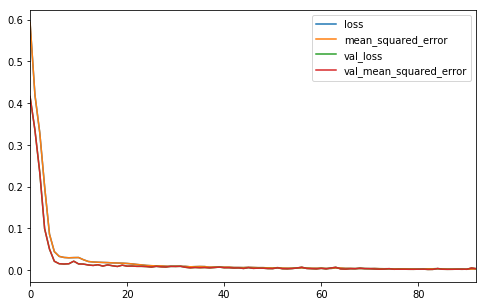

In [13]:
pd.DataFrame(history).plot(figsize=(8, 5))

## Predict on validation split (reconstruct defect-free validation images)

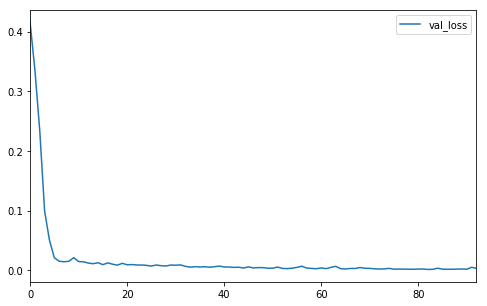

In [14]:
pd.DataFrame(history[['val_loss']]).plot(figsize=(8, 5))

In [15]:
# This will do preprocessing
validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255, validation_split=validation_split, zca_epsilon=1e-06,
)

# Generate validation batches with datagen.flow_from_directory()
validation_generator = validation_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=(256, 256),
    color_mode=color_mode,
    batch_size=1,
    shuffle=False,
    class_mode="input",
    subset="validation",
)

# Generate input-image batches with datagen.flow_from_directory()
input_generator = validation_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=(256, 256),
    color_mode=color_mode,
    batch_size=1,
    shuffle=False,
    class_mode="input",
    subset="validation",
)

Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


In [16]:
# retrieve preprocessed input images as a numpy array
nb_images = input_generator.samples
imgs_input = np.zeros(shape=(nb_images, 256, 256, channels))
for i in range(nb_images):
    img_input = input_generator.next()[0]
    imgs_input[i, :, :, :] = img_input

In [17]:
imgs_input.shape

(21, 256, 256, 3)

In [18]:
def plot_img(imgs, index):
    if imgs.shape[-1] == 3:
        plt.imshow(imgs[index])
    else:
        plt.imshow(imgs[index,:,:,0], cmap=plt.cm.gray)
    plt.show()

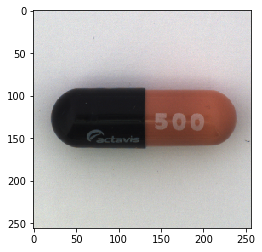

In [19]:
# plt.imshow(inputs[0]) # rgb
# plt.imshow(inputs[0,:,:,0], cmap=plt.cm.gray)
plot_img(imgs_input, 0)

--------------------------------------------------------------------------------------------------

### Inspect reconstructions through predict_generator

In [20]:
# get reconstructed images (predictions)
imgs_pred = model.predict_generator(
    validation_generator,
#     steps=validation_generator.samples / batch_size,
    steps=validation_generator.samples,
    verbose=1,
)

Instructions for updating:
Please use Model.predict, which supports generators.
21/21 [==============================] - 4s 167ms/step


In [21]:
imgs_pred.shape

(21, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


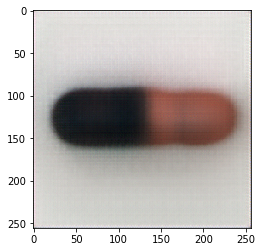

In [26]:
# plt.imshow(imgs_pred[20])
# plt.imshow(imgs_pred[0,:,:,0], cmap=plt.cm.gray)
plot_img(imgs_pred, index=0)

In [23]:
np.amax(imgs_pred)

1.0239155

In [24]:
np.amin(imgs_pred)

0.011560649

--------------------------------------------------------------------------------------------------

### Inspect reconstructions throught predict

In [36]:
imgs_pred = model.predict(imgs_input)

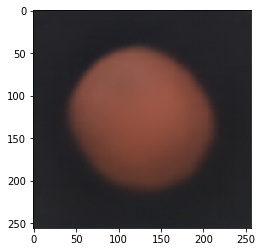

In [18]:
plt.imshow(imgs_pred[20])

In [27]:
np.amax(imgs_pred)

0.7803083

In [28]:
np.amin(imgs_pred)

0.10482304

--------------------------------------------------------------------------------------------------

In [32]:
imgs_diff = imgs_input - imgs_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


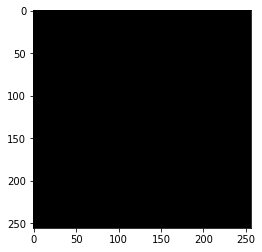

In [33]:
# plt.imshow(imgs_diff[20])
plot_img(imgs_diff, 0)

In [34]:
np.amax(imgs_diff)

5.9604645e-07

In [51]:
np.amin(imgs_diff)

-7.1525574e-07

--------------------------------------------------------------------------------------------------

---------------------------------------------------------

In [94]:
np.amin(imgs_inputs[0:1,:,:,:])

0.09019608050584793

In [71]:
from custom_loss_functions import mssim

In [107]:
batch_input = tf.convert_to_tensor(imgs_input[0:4,:,:,:], dtype=tf.float32) 
batch_pred = tf.convert_to_tensor(imgs_pred[0:4,:,:,:], dtype=tf.float32)

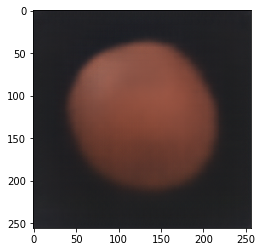

In [108]:
plt.imshow(batch_pred[0])

In [109]:
batch_input.shape

TensorShape([4, 256, 256, 3])

In [110]:
batch_pred.shape

TensorShape([4, 256, 256, 3])

In [111]:
test_tensor = tf.image.ssim_multiscale(batch_input, batch_pred, 1.0)

In [112]:
test_tensor.shape

TensorShape([4])

In [113]:
print(test_tensor)

tf.Tensor([0.87911576 0.90647703 0.8998406  0.890752  ], shape=(4,), dtype=float32)


In [133]:
print(tf.image.ssim_multiscale(batch_recon , batch_input, 1.0))

tf.Tensor([0.87911576 0.90647703 0.8998406  0.890752  ], shape=(4,), dtype=float32)


In [134]:
loss = (1 - K.mean(tf.image.ssim_multiscale(batch_input, batch_recon, 1.0), axis=-1))

In [135]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.105953634>

In [116]:
loss_mse = tf.keras.losses.MSE(
    batch_input,
    batch_recon
)

In [119]:
loss_mse.shape

TensorShape([4, 256, 256])

In [127]:
loss_mse.numpy().sum()

223.71962

In [129]:
loss_l2 = tf.nn.l2_loss(batch_input-batch_recon)

In [130]:
print(loss_l2)

tf.Tensor(335.5794, shape=(), dtype=float32)


In [74]:
test_tensor = mssim_loss(batch_input, batch_input)

In [75]:
type(test_tensor)

tensorflow.python.framework.ops.EagerTensor

In [76]:
test_tensor_np = test_tensor.numpy()

In [77]:
test_tensor_np.shape

()

### Compute residual maps

In [27]:
imgs_diff = imgs_input - imgs_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


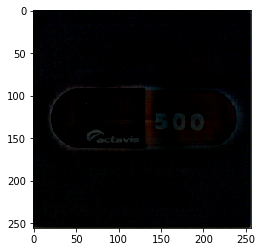

In [28]:
# plt.imshow(imgs_diff[0])
# plt.imshow(imgs_diff[0,:,:,0], cmap=plt.cm.gray)
plot_img(imgs_diff, index=0)

In [29]:
type(imgs_diff)

numpy.ndarray

In [30]:
imgs_diff_1d = imgs_diff.flatten()

(array([3.000000e+00, 1.000000e+00, 3.000000e+00, 8.000000e+00,
        5.300000e+01, 1.630000e+02, 4.480000e+02, 1.030000e+03,
        2.018000e+03, 3.410000e+03, 6.413000e+03, 1.270300e+04,
        2.389800e+04, 4.989700e+04, 1.244510e+05, 3.362040e+05,
        8.119540e+05, 1.324904e+06, 9.466910e+05, 2.793010e+05,
        7.574500e+04, 4.270200e+04, 3.279500e+04, 2.207000e+04,
        1.376300e+04, 8.614000e+03, 4.738000e+03, 2.429000e+03,
        1.271000e+03, 5.310000e+02, 1.910000e+02, 7.800000e+01,
        6.500000e+01, 2.900000e+01, 3.100000e+01, 3.500000e+01,
        5.000000e+01, 4.600000e+01, 2.700000e+01, 5.000000e+00]),
 array([-0.37056559, -0.34972349, -0.32888138, -0.30803928, -0.28719718,
        -0.26635507, -0.24551297, -0.22467086, -0.20382876, -0.18298665,
        -0.16214455, -0.14130244, -0.12046034, -0.09961824, -0.07877613,
        -0.05793403, -0.03709192, -0.01624982,  0.00459229,  0.02543439,
         0.04627649,  0.0671186 ,  0.0879607 ,  0.10880281,  0.129

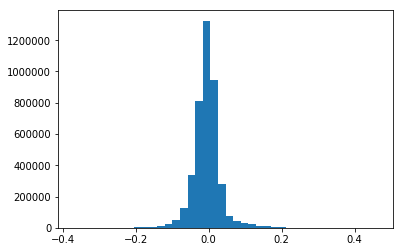

In [31]:
plt.hist(imgs_diff_1d, bins=40)

In [ ]:
hist = np.historgram(imgs_diff_1d)

In [42]:
val_data_dir

'mvtec/capsule/train'

In [ ]:
index = 1
plt.imshow(inputs[index])
img_original = tf.expand_dims(inputs[index], 0)
img_reconstruction = model.predict(img_original)
plt.imshow(img_reconstruction[0])